In [2]:
import numpy as np
import tensorflow as tf

1. 设计一个单隐藏层神经网络，隐藏神经元个数等于2，并确定模型参数，以解决XOR问题

In [22]:
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam
from keras.layers import Dense
from keras.activations import sigmoid

In [23]:
class MixedAPIANN(tf.keras.Model):
    def __init__(self, input_dims : int=1, output_dims : int=1, hidden_size : int=8, *args, **kwargs):
        super().__init__(*args,**kwargs)
        self.input_dims = input_dims
        self.output_dims = output_dims
        self.hidden_size = hidden_size

        self.dense1 = Dense(hidden_size, activation=sigmoid)
        self.dense2 = Dense(output_dims,activation=sigmoid)
    
    def call(self, inputs, training=None, mask=None):
        X = self.dense1(inputs)
        y = self.dense2(X)
        return y

In [24]:
def train(model, X : tf.Tensor, y : tf.Tensor, batch_size : int=32, epochs : int=200, lr : float=0.1):
    optimizer = Adam(learning_rate=lr) # 创建优化器
    BC = BinaryCrossentropy() # 实例化损失函数

    for epoch in range(epochs):
        # 使用 Tensorflow API 创建批量数据的生成器
        batch_data = tf.data.Dataset.from_tensor_slices((X,y)).batch(batch_size=batch_size).shuffle(buffer_size=batch_size)
        for x_batch, y_batch in batch_data:
            # 跟踪梯度
            with tf.GradientTape() as tape:
                y_hat = model(x_batch)
                loss = BC(y_batch,y_hat)
            
            # 选取参数，计算梯度
            weights = model.trainable_variables
            grads = tape.gradient(loss,weights)
            optimizer.apply_gradients(zip(grads,weights)) # 直接调用优化器 API
    
    return model

In [25]:
x, y = np.array([[0,0],[0,1],[1,0],[1,1]]), np.array([[0],[1],[1],[0]])
x, y = tf.constant(x,dtype=tf.float32), tf.constant(y,dtype=tf.float32)
model = MixedAPIANN(hidden_size=2)
model = train(model,X=x,y=y,epochs=100,lr=0.1,batch_size=4)

In [26]:
model(x)

<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
array([[0.03672487],
       [0.9495435 ],
       [0.9493684 ],
       [0.08835044]], dtype=float32)>

2. 尝试调整第2节中解决回归问题的ANN的隐藏层神经元个数，查看拟合效果与隐藏神经元个数的关系，你可以用任何方法实现该神经网络（手动计算梯度，低层级API，高层级API，混合API，推荐使用混合API）

### 混合API调整

In [8]:
from keras.losses import MeanSquaredError
from keras.optimizers import SGD
from keras.layers import Dense
from keras.activations import sigmoid

In [9]:
class MixedAPIANN(tf.keras.Model):
    def __init__(self, input_dims : int=1, output_dims : int=1, hidden_size : int=8, *args, **kwargs):
        super().__init__(*args,**kwargs)
        self.input_dims = input_dims
        self.output_dims = output_dims
        self.hidden_size = hidden_size

        self.dense1 = Dense(hidden_size,activation=sigmoid)
        self.dense2 = Dense(output_dims)
    
    def call(self, inputs, training=None, mask=None):
        X = self.dense1(inputs)
        y = self.dense2(X)
        return y

In [10]:
def train(model, X : tf.Tensor, y : tf.Tensor, batch_size : int=32, epochs : int=200, lr : float=0.1):
    optimizer = SGD(learning_rate=lr)
    mse = MeanSquaredError() 

    for epoch in range(epochs):
        batch_data = tf.data.Dataset.from_tensor_slices((X,y)).batch(batch_size=batch_size).shuffle(buffer_size=batch_size)
        for x_batch, y_batch in batch_data:
            # 跟踪梯度
            with tf.GradientTape() as tape:
                y_hat = model(x_batch)
                loss = mse(y_batch,y_hat)
            
            # 选取参数，计算梯度
            weights = model.trainable_variables
            grads = tape.gradient(loss,weights)
            optimizer.apply_gradients(zip(grads,weights)) # 直接调用优化器API
    
    return model, loss

In [40]:
# 生成数据
from source.code import ch1
x, y, func = ch1.build_regression(N=200)
x, y = tf.constant(x,dtype=tf.float32), tf.constant(y,dtype=tf.float32)

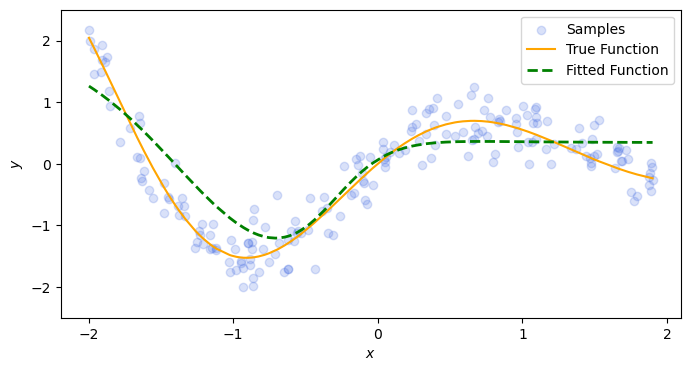

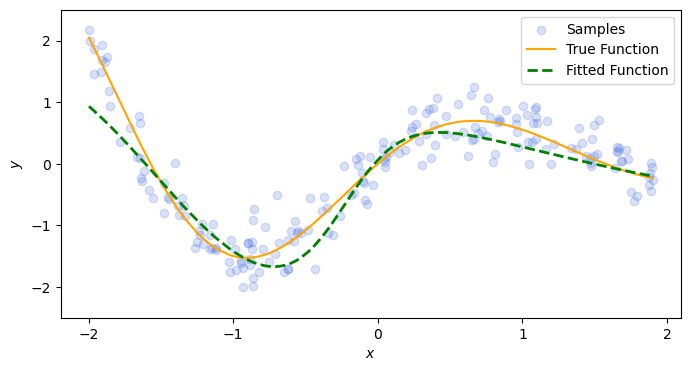

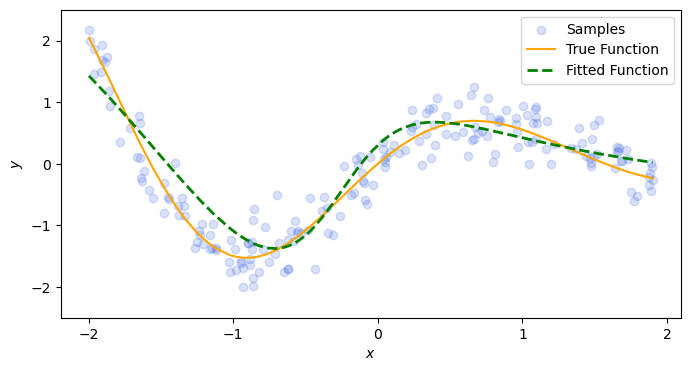

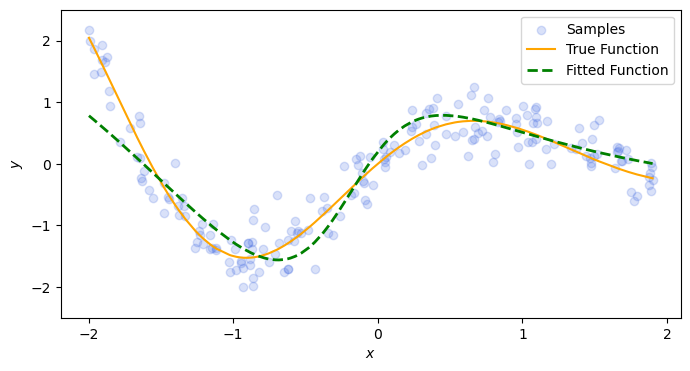

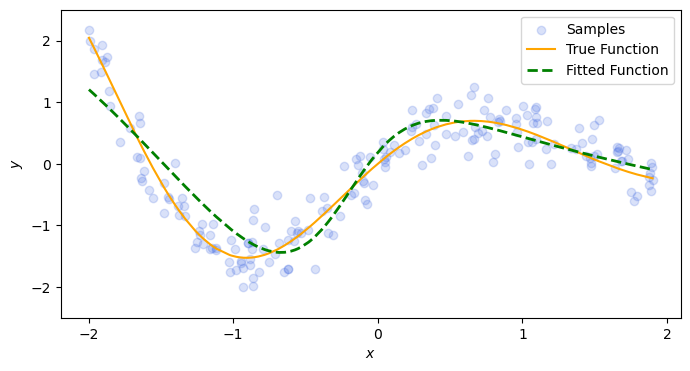

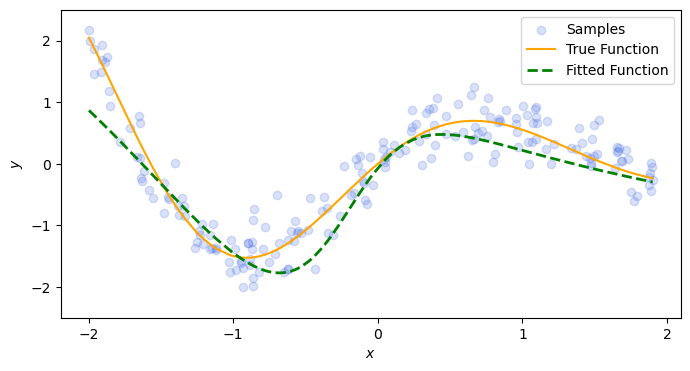

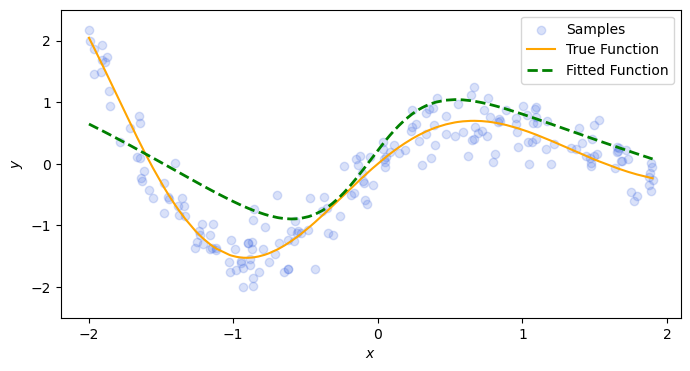

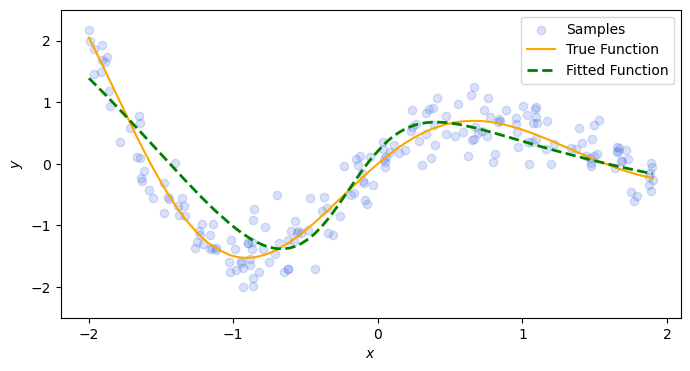

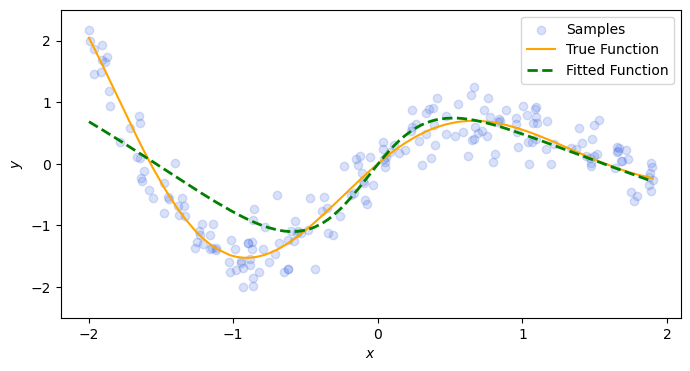

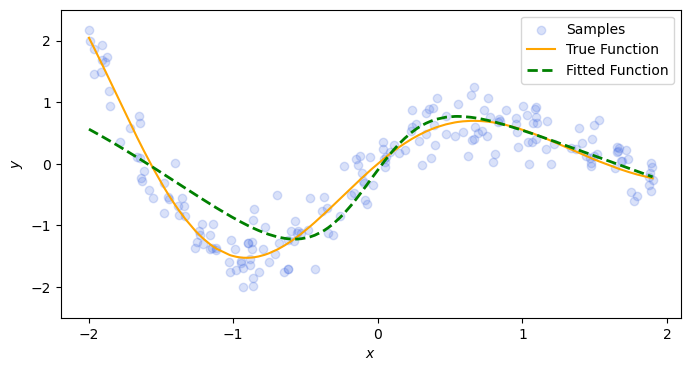

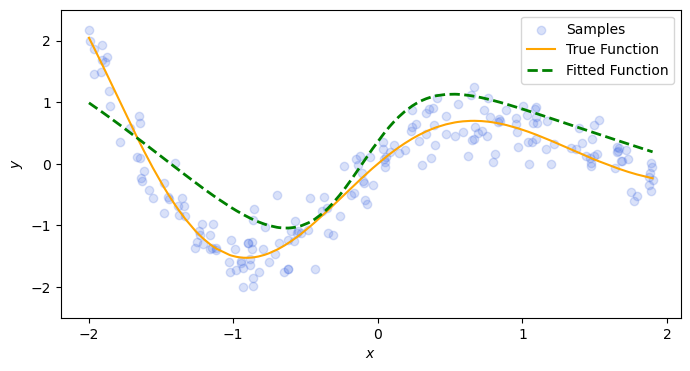

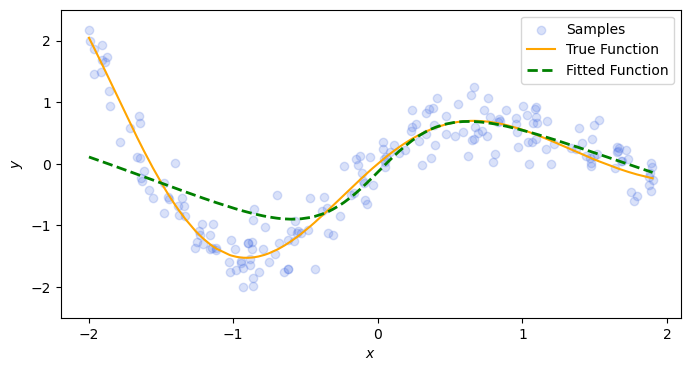

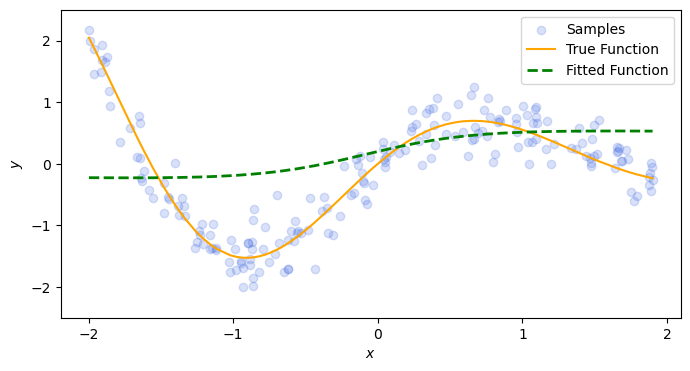

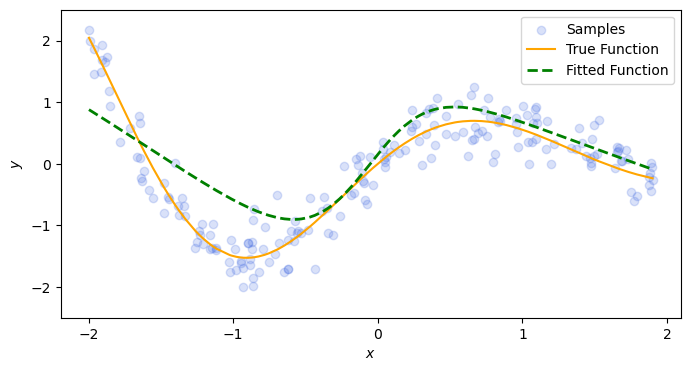

In [41]:
#查看hidden_size和loss的关系
hidden_size_list = list(range(2,30,2))
loss_list = []
for hidden_size in hidden_size_list:
    model = MixedAPIANN(hidden_size=hidden_size)
    model, loss = train(model,X=x,y=y,epochs=200,lr=0.1,batch_size=32)
    loss_list.append(loss.numpy())
    func_fit = model(x).numpy() # 需要将 tf.Tensor 数据转换为 np.ndarray
    ch1.regression_plot(x,y,func,x,func_fit)

In [42]:
from matplotlib import pyplot as plt

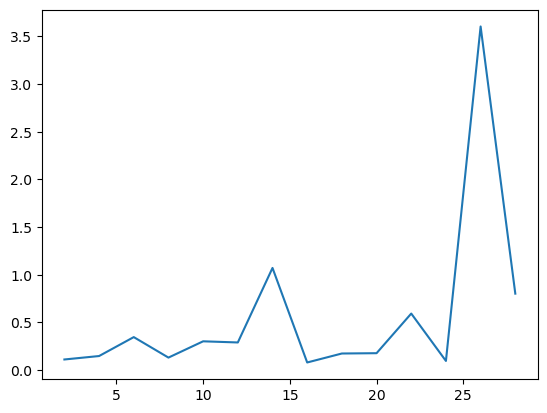

In [43]:
plt.plot(hidden_size_list, loss_list)

通过多次实验发现，对一定的循环次数而言，当隐藏层参数选的过多或过少时，尤其是过多时，模型会有较严重的欠拟合(不稳定)现象，具体表现为，在多次实验中其拟合曲线形状的随机性较大，模型不稳定

3. 使用`ch1_build_classification()`生成二维二分类数据集，完成下面的任务：
   1. 在3.2节模型的基础上，使用低层级API搭建一个单隐藏层神经网络，用于解决该二分类问题
      * 回顾机器学习相关知识，为了对二分类问题的概率分布建模，神经网络的输出层 $f(x)$ 还需要施加什么额外变换？
      * 模型应该使用什么损失函数？
   2. 汇报模型在训练集和测试集上的准确率
   3. 绘制训练集和测试集的损失函数值随着迭代次数`epochs`的变换情况
   4. 用高层级API实现上面的神经网络分类模型
   5. 绘制神经网络模型的决策边界

### 高层级API方法

In [27]:
from keras.models import Sequential # 序列模型
from keras.layers import Input, Dense # MLP / FCN全连接层
from keras.activations import sigmoid # 激活函数
from keras.losses import BinaryCrossentropy #二分类交叉熵损失
from keras.optimizers import SGD # 随机梯度下降优化算法
from keras.metrics import BinaryAccuracy #度量指标为二分类正确率

In [28]:
hidden_size = 32
model = Sequential([
    Input(shape=(2)), # 输入层，特征维度为 2
    Dense(hidden_size,activation=sigmoid), # 设置隐藏层，设置激活函数
    Dense(1, activation=sigmoid) # 设置输出层，设置激活函数，输出维度为 1
])

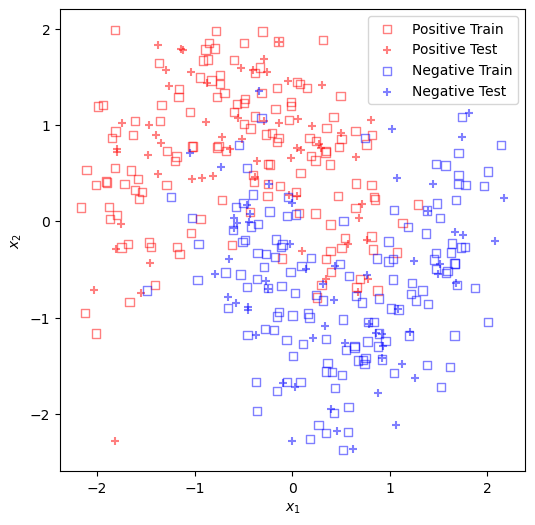

In [46]:
from source.code import ch1
# 生成二分类数据集
X_train, X_test, y_train, y_test = ch1.build_classification(N=400,noise=0.3,show=True)
y_train =y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))
X_train, y_train = tf.constant(X_train,dtype=tf.float32), tf.constant(y_train,dtype=tf.float32)
X_test, y_test = tf.constant(X_test,dtype=tf.float32), tf.constant(y_test,dtype=tf.float32)
model.compile(optimizer=SGD(learning_rate=0.05),loss=BinaryCrossentropy(),metrics=BinaryAccuracy())

In [47]:
# 训练模型
model.fit(x=X_train, y=y_train, batch_size=16, epochs=100)

Epoch 1/100
18/18 [==============================] - 0s 2ms/step - loss: 0.3020 - binary_accuracy: 0.8786
Epoch 2/100
18/18 [==============================] - 0s 1ms/step - loss: 0.3010 - binary_accuracy: 0.8714
Epoch 3/100
18/18 [==============================] - 0s 1ms/step - loss: 0.3018 - binary_accuracy: 0.8714
Epoch 4/100
18/18 [==============================] - 0s 2ms/step - loss: 0.3015 - binary_accuracy: 0.8821
Epoch 5/100
18/18 [==============================] - 0s 1ms/step - loss: 0.3005 - binary_accuracy: 0.8750
Epoch 6/100
18/18 [==============================] - 0s 1ms/step - loss: 0.2998 - binary_accuracy: 0.8679
Epoch 7/100
18/18 [==============================] - 0s 1ms/step - loss: 0.2997 - binary_accuracy: 0.8750
Epoch 8/100
18/18 [==============================] - 0s 1ms/step - loss: 0.2999 - binary_accuracy: 0.8786
Epoch 9/100
18/18 [==============================] - 0s 1ms/step - loss: 0.3007 - binary_accuracy: 0.8679
Epoch 10/100
18/18 [==========================

### 高层级API决策边界

In [48]:
from matplotlib import pyplot as plt

In [49]:
x1 = np.linspace(-2,2,50)
x2 = np.linspace(-2,2,50)
x1, x2 = np.meshgrid(x1,x2)
X = np.vstack([x1.flatten(),x2.flatten()]).T

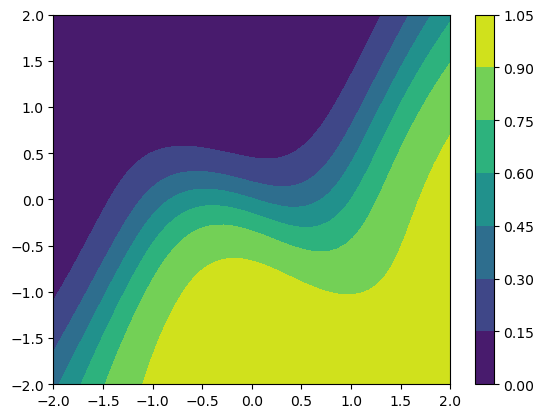

In [50]:
prob = model(X).numpy()
prob = prob.reshape((50,50))
plt.contourf(x1,x2,prob)
plt.colorbar()

### 低层级API方法

In [34]:
def sigmoid_tf(x : tf.Variable):
    return 1 / (1 + tf.exp(-x))

def loss_func_tf(y_true : tf.Variable, y_pred : tf.Variable):
    return -tf.reduce_mean(y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))

def BatchGenerator_tf(x : np.ndarray, y : np.ndarray, batch_size : int=32):
    return tf.data.Dataset.from_tensor_slices((x,y)).batch(batch_size).shuffle(x.shape[0])

#将输出的概率转换为类别0，1
def classify(x : tf.Tensor):
    y = []
    for xx in x.numpy():
        if xx > 0.5:
            y.append(1)
        else:
            y.append(0)
    return tf.constant(y, dtype=tf.float32)

#准确率函数
def accuracy(y_true : tf.constant, y_hat: tf.constant):
    N = y_true.shape[0]
    n = np.sum(y_true == y_hat)
    return n / N

In [35]:
class LowAPIANN(tf.keras.Model):
    def __init__(self, input_dims : int=2, output_dims : int=1, hidden_size : int=8, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.input_dims = input_dims
        self.output_dims = output_dims
        self.hidden_size = hidden_size

        # 声明为 tf.Variable
        self.w1 = tf.Variable(np.random.randn(input_dims,hidden_size),dtype=tf.float32,name="w1")
        self.b1 = tf.Variable(np.random.randn(hidden_size),dtype=tf.float32,name="b1")
        self.w2 = tf.Variable(np.random.randn(hidden_size,output_dims),dtype=tf.float32,name="w2")
        self.b2 = tf.Variable(np.random.randn(output_dims),dtype=tf.float32,name="b2")
    
    def call(self, inputs, training=None, mask=None):
        h1 = inputs @ self.w1 + self.b1
        z = sigmoid_tf(h1)
        h2 = z @ self.w2 + self.b2
        y = sigmoid_tf(h2)

        return y

In [36]:
# BatchSGD 训练模型
def train(model, X : tf.Tensor, y : tf.Tensor, batch_size : int=32, epochs : int=200, lr : float=0.1):
    for epoch in range(epochs):
        # 该轮迭代的批量生成器
        batch_data = BatchGenerator_tf(X,y,batch_size=batch_size)
        for x_batch, y_batch in batch_data:
            # 跟踪梯度
            with tf.GradientTape() as tape:
                y_hat = model(x_batch)
                loss = loss_func_tf(y_batch,y_hat)
            
            # 选取参数，计算梯度
            weights = model.trainable_variables
            grads = tape.gradient(loss,weights)
            # 梯度下降更新参数
            for weight, grad in zip(weights,grads):
                # assign_sub 等价于 weight 自身减去这个更新量
                # Tensorflow 参数不允许使用 weight -= lr*grad 这种语法
                weight.assign_sub(lr*grad)
        
        # 打印损失
        if epoch == 0 or (epoch+1)%10 == 0:
            y_hat = model(X)
            loss = loss_func_tf(y,y_hat).numpy()
            print("epoch: %4d, loss: %.4f"%(epoch+1,loss))
    
    return model

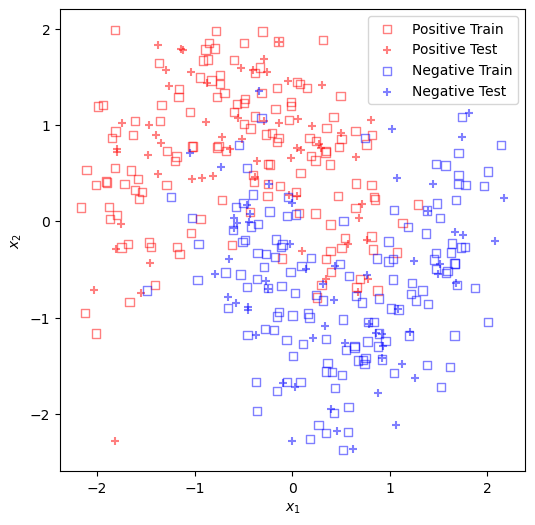

In [37]:
from source.code import ch1
# 生成二分类数据集
X_train, X_test, y_train, y_test = ch1.build_classification(N=400,noise=0.3,show=True)
y_train =y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))
X_train, y_train = tf.constant(X_train,dtype=tf.float32), tf.constant(y_train,dtype=tf.float32)
X_test, y_test = tf.constant(X_test,dtype=tf.float32), tf.constant(y_test,dtype=tf.float32)

In [38]:
model = LowAPIANN(hidden_size=32)

In [39]:
model = train(model, X_train, y_train, batch_size=16, epochs=100, lr=0.05)

epoch:    1, loss: 0.5490
epoch:   10, loss: 0.3488
epoch:   20, loss: 0.3367
epoch:   30, loss: 0.3301
epoch:   40, loss: 0.3249
epoch:   50, loss: 0.3206
epoch:   60, loss: 0.3156
epoch:   70, loss: 0.3129
epoch:   80, loss: 0.3078
epoch:   90, loss: 0.3038
epoch:  100, loss: 0.3007


In [40]:
# 将输出的概率转换为类别0，1
def classify(prob : tf.Tensor, threshold : float=0.5):
    return tf.cast(prob > threshold, dtype=tf.float32).numpy()

In [41]:
thres = 0.5
y_train_hat = classify(model(X_train),thres)
y_test_hat = classify(model(X_test),thres)

In [42]:
acc_train = accuracy(y_train, y_train_hat)
acc_test = accuracy(y_test, y_test_hat)
print(acc_train)
print(acc_test)

0.8714285714285714
0.8333333333333334


### 低层级API决策边界

In [43]:
from matplotlib import pyplot as plt

In [44]:
x1 = np.linspace(-2,2,50)
x2 = np.linspace(-2,2,50)
x1, x2 = np.meshgrid(x1,x2)
X = np.vstack([x1.flatten(),x2.flatten()]).T

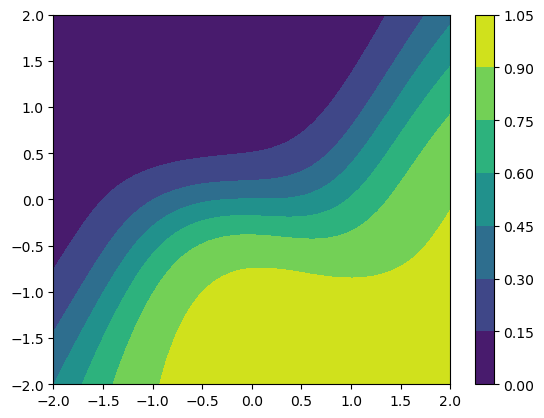

In [45]:
prob = model(X).numpy()
prob = prob.reshape((50,50))
plt.contourf(x1,x2,prob)
plt.colorbar()